In [30]:
import pandas as pd
import numpy as np
import datetime
import random
from itertools import cycle
from keras.models import Sequential
from keras.layers import Dense, LSTM
from math import sqrt, floor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

In [31]:

df_s = pd.read_csv("second_data.csv", index_col=0)

df_s.head()

,count
0,87
1,76
2,81
3,110
4,78


In [32]:
# Keep getting data from our df_m (minute) data in a circular way
# This allows us to generate data and keep repeating until we run out of days in our dataset
def get_circular_data():
    circular_list = cycle(df_s["count"].values)
    return circular_list

def generate_data(start, end, step, my_func):
    dt_first_timestamp_in_sec = int(start.timestamp())
    dt_first_timestamp_in_sec

    result = []
    while start < end:
        timestamp = start.strftime('%Y-%m-%d %H:%M:%S')
        result.append({"timestamp":timestamp,
                       "value": next(my_func)
                      })
        start += step
    return result

In [33]:
# Generate some data from Feb 1st 2019 to Feb 5th 2019
start = datetime.datetime(2019, 2, 1)
end = datetime.datetime(2019, 3, 5, 23, 59, 59)
step = datetime.timedelta(seconds=1) # By minutes (because we're using our minute dataset)

df = pd.DataFrame(generate_data(start,end,step,get_circular_data()))

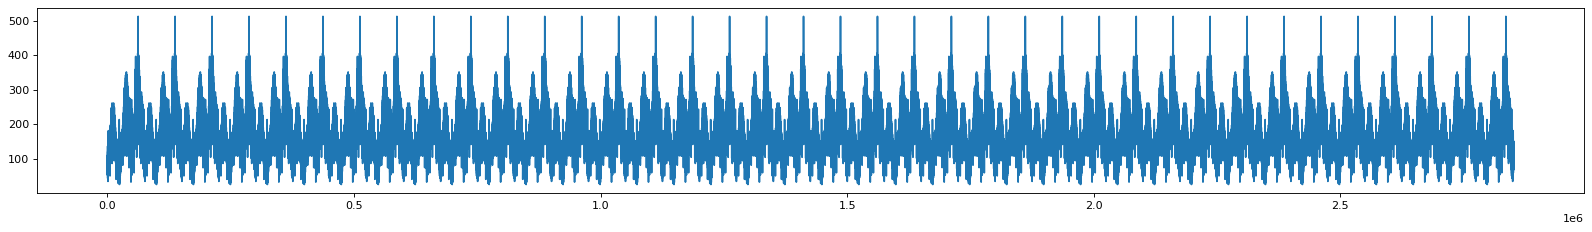

In [34]:
pyplot.figure(figsize=(20,3), dpi=80)
pyplot.plot(df["value"])
pyplot.tight_layout()
pyplot.show()

In [35]:
# Latency is loosely related to traffic volume
#  Although good systems don't see an increase in latency when the traffic increases
def latency(value):
    latency = 500 # 100 ms is the default
    
    if value > 9000:
        latency = latency * (1.01+random.uniform(0, 1))
    if value > 11000:
        latency = latency * (1.09+random.uniform(0, 1))
    if value < 5000:
        latency = latency * (0.7+random.uniform(0, 1))
    
    return latency
    
# We don't want to see many database errors, so let's simulate rare occurences
def db_errors(value, host_num):
    if host_num == 1:
        1 if random.randint(0,100000) > 77777 else np.NaN
    if host_num == 2:
        1 if random.randint(0,100000) > 99998 else np.NaN
    if host_num == 3:
        1 if random.randint(0,1000000) > 999999 else np.NaN
    
    return 1 if random.randint(0,100) > 99 else np.NaN

In [36]:
df["http_500"] = df["value"]*.05 # Server Error
df["http_404"] = df["value"]*.1 # Page not found
df["http_200"] = df["value"]*5 # OK

df["login_success"] = df["value"]*.6
df["latency"] = df["value"].apply(lambda x: latency(x))


df["db_errors_host01"] = df["value"].apply(lambda x: db_errors(x,1))
df["db_errors_host02"] = df["value"].apply(lambda x: db_errors(x,2))
df["db_errors_host03"] = df["value"].apply(lambda x: db_errors(x,3))

In [37]:
# convert series to supervised learning
# developed in this blog post https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [38]:
df = df.set_index('timestamp')
df.head()

,value,http_500,http_404,http_200,login_success,latency,db_errors_host01,db_errors_host02,db_errors_host03
timestamp,,,,,,,,,
2019-02-01 00:00:00,87,4.35,8.7,435,52.2,448.458458,NaN,NaN,NaN
2019-02-01 00:00:01,76,3.80,7.6,380,45.6,639.368699,NaN,NaN,NaN
2019-02-01 00:00:02,81,4.05,8.1,405,48.6,664.160379,NaN,NaN,NaN
2019-02-01 00:00:03,110,5.50,11.0,550,66.0,646.984868,1.0,NaN,NaN
2019-02-01 00:00:04,78,3.90,7.8,390,46.8,357.510225,NaN,NaN,NaN


In [39]:
# Replace Null values with 0's
df['db_errors_host01'].fillna(0, inplace=True)
df['db_errors_host02'].fillna(0, inplace=True)
df['db_errors_host03'].fillna(0, inplace=True)
df.head()

,value,http_500,http_404,http_200,login_success,latency,db_errors_host01,db_errors_host02,db_errors_host03
timestamp,,,,,,,,,
2019-02-01 00:00:00,87,4.35,8.7,435,52.2,448.458458,0.0,0.0,0.0
2019-02-01 00:00:01,76,3.80,7.6,380,45.6,639.368699,0.0,0.0,0.0
2019-02-01 00:00:02,81,4.05,8.1,405,48.6,664.160379,0.0,0.0,0.0
2019-02-01 00:00:03,110,5.50,11.0,550,66.0,646.984868,1.0,0.0,0.0
2019-02-01 00:00:04,78,3.90,7.8,390,46.8,357.510225,0.0,0.0,0.0


In [40]:
values = df.values

In [41]:
# integer encoding of labels (not using yet here)
#encoder = LabelEncoder()
#values[:,1] = encoder.fit_transform(values[:,1])

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# Drop Columns of Variables We Aren't Predicting
reframed.drop(reframed.columns[[10, 11, 12, 13, 14, 15, 16, 17]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var1(t)
1,0.125257,0.125257,0.125257,0.125257,0.125257,0.196917,0.0,0.0,0.0,0.102669
2,0.102669,0.102669,0.102669,0.102669,0.102669,0.578738,0.0,0.0,0.0,0.112936
3,0.112936,0.112936,0.112936,0.112936,0.112936,0.628322,0.0,0.0,0.0,0.172485
4,0.172485,0.172485,0.172485,0.172485,0.172485,0.593971,1.0,0.0,0.0,0.106776
5,0.106776,0.106776,0.106776,0.106776,0.106776,0.015020,0.0,0.0,0.0,0.135524


In [52]:
# split into train and test sets
values = reframed.values
n_train_minutes = floor(len(values) * 0.2)
train = values[:n_train_minutes, :]
test = values[n_train_minutes:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(570239, 1, 9) (570239,) (2280959, 1, 9) (2280959,)


Epoch 1/50
2852/2852 - 14s - loss: 0.0463 - val_loss: 0.0691
Epoch 2/50
2852/2852 - 12s - loss: 0.0439 - val_loss: 0.0628
Epoch 3/50
2852/2852 - 12s - loss: 0.0429 - val_loss: 0.0586
Epoch 4/50
2852/2852 - 12s - loss: 0.0422 - val_loss: 0.0552
Epoch 5/50
2852/2852 - 12s - loss: 0.0416 - val_loss: 0.0529
Epoch 6/50
2852/2852 - 12s - loss: 0.0412 - val_loss: 0.0513
Epoch 7/50
2852/2852 - 12s - loss: 0.0409 - val_loss: 0.0503
Epoch 8/50
2852/2852 - 12s - loss: 0.0409 - val_loss: 0.0496
Epoch 9/50
2852/2852 - 12s - loss: 0.0409 - val_loss: 0.0491
Epoch 10/50
2852/2852 - 12s - loss: 0.0408 - val_loss: 0.0487
Epoch 11/50
2852/2852 - 12s - loss: 0.0408 - val_loss: 0.0485
Epoch 12/50
2852/2852 - 12s - loss: 0.0407 - val_loss: 0.0483
Epoch 13/50
2852/2852 - 12s - loss: 0.0406 - val_loss: 0.0482
Epoch 14/50
2852/2852 - 12s - loss: 0.0406 - val_loss: 0.0482
Epoch 15/50
2852/2852 - 12s - loss: 0.0405 - val_loss: 0.0481
Epoch 16/50
2852/2852 - 12s - loss: 0.0405 - val_loss: 0.0480
Epoch 17/50
2852/

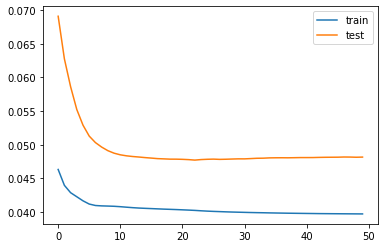

In [53]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=200, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [54]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [55]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
normalized_rmse = rmse/(max(max(inv_yhat),max(inv_y))-min(min(inv_yhat),min(inv_y)))
print('Normalized RMSE: %.3f' % normalized_rmse)

Test RMSE: 29.080
Normalized RMSE: 0.060


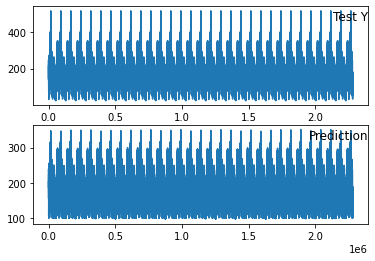

In [56]:
pyplot.subplot(2, 1, 1)
pyplot.plot(inv_y, label="Test Y")
pyplot.title("Test Y", y=0.8, loc='right')
pyplot.subplot(2, 1, 2)
pyplot.plot(inv_yhat, label="Prediction")
pyplot.title("Prediction", y=0.8, loc='right')
pyplot.show()